In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
df = pd.read_csv("Driver_Behavior_.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (30000, 10)


,accel_x,accel_y,brake_pressure,steering_angle,throttle,lane_deviation,phone_usage,headway_distance,reaction_time,behavior_label
0,NaN,NaN,23.107812,-3.169956,NaN,0.851871,NaN,NaN,1.40005,Distracted
1,NaN,NaN,36.961137,NaN,NaN,NaN,NaN,29.904182,NaN,Distracted
2,3.638434,NaN,NaN,NaN,78.110507,NaN,NaN,11.126012,NaN,Aggressive
3,NaN,0.039135,45.007002,NaN,NaN,NaN,NaN,NaN,NaN,Aggressive
4,NaN,NaN,38.759612,NaN,NaN,NaN,NaN,NaN,NaN,Distracted


In [ ]:
df.info()

missing_count = df.isna().sum()
missing_pct = (missing_count / len(df)) * 100

quality_df = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Percentage": missing_pct.round(2)
}).sort_values("Missing_Count", ascending=False)

display(quality_df)

print("Duplicate rows:", df.duplicated().sum())

df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   accel_x           8400 non-null   float64
 1   accel_y           7500 non-null   float64
 2   brake_pressure    6600 non-null   float64
 3   steering_angle    8100 non-null   float64
 4   throttle          7200 non-null   float64
 5   lane_deviation    5400 non-null   float64
 6   phone_usage       9600 non-null   float64
 7   headway_distance  7800 non-null   float64
 8   reaction_time     6000 non-null   float64
 9   behavior_label    30000 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.3+ MB


,Missing_Count,Missing_Percentage
lane_deviation,24600,82.0
reaction_time,24000,80.0
brake_pressure,23400,78.0
throttle,22800,76.0
accel_y,22500,75.0
headway_distance,22200,74.0
steering_angle,21900,73.0
accel_x,21600,72.0
phone_usage,20400,68.0
behavior_label,0,0.0


Duplicate rows: 3440


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
accel_x,8400.0,NaN,NaN,NaN,1.271529,1.020391,-0.664206,0.509506,0.838319,1.997647,5.08025
accel_y,7500.0,NaN,NaN,NaN,0.365069,0.293385,-0.439029,0.115808,0.303461,0.564457,1.664605
brake_pressure,6600.0,NaN,NaN,NaN,40.612986,26.45927,0.010935,18.686603,39.858006,57.499146,99.994365
steering_angle,8100.0,NaN,NaN,NaN,0.046692,11.427219,-52.362237,-6.209093,-0.000217,6.236984,53.426806
throttle,7200.0,NaN,NaN,NaN,55.547654,21.654502,20.0153,37.760247,51.650045,71.823208,99.977772
lane_deviation,5400.0,NaN,NaN,NaN,0.571632,0.423747,0.000499,0.238255,0.451736,0.812363,2.425784
phone_usage,9600.0,NaN,NaN,NaN,0.332083,0.470985,0.0,0.0,0.0,1.0,1.0
headway_distance,7800.0,NaN,NaN,NaN,23.285303,11.944655,5.004651,13.617753,20.038754,31.19616,49.989017
reaction_time,6000.0,NaN,NaN,NaN,0.998652,0.462127,0.400008,0.626133,0.848814,1.394912,1.999836
behavior_label,30000,3,Distracted,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_clean = df.copy()

# Create acceleration magnitude (overall vehicle acceleration)
df_clean["accel_magnitude"] = np.sqrt(
    df_clean["accel_x"]**2 + df_clean["accel_y"]**2
)

# Steering intensity (absolute steering angle)
df_clean["steering_intensity"] = df_clean["steering_angle"].abs()

# Risk score combining multiple risky factors
df_clean["risk_score"] = (
    df_clean["brake_pressure"] +
    df_clean["lane_deviation"] +
    df_clean["reaction_time"] +
    df_clean["phone_usage"]
)

df_clean.head()


,accel_x,accel_y,brake_pressure,steering_angle,throttle,lane_deviation,phone_usage,headway_distance,reaction_time,behavior_label,accel_magnitude,steering_intensity,risk_score
0,NaN,NaN,23.107812,-3.169956,NaN,0.851871,NaN,NaN,1.40005,Distracted,NaN,3.169956,NaN
1,NaN,NaN,36.961137,NaN,NaN,NaN,NaN,29.904182,NaN,Distracted,NaN,NaN,NaN
2,3.638434,NaN,NaN,NaN,78.110507,NaN,NaN,11.126012,NaN,Aggressive,NaN,NaN,NaN
3,NaN,0.039135,45.007002,NaN,NaN,NaN,NaN,NaN,NaN,Aggressive,NaN,NaN,NaN
4,NaN,NaN,38.759612,NaN,NaN,NaN,NaN,NaN,NaN,Distracted,NaN,NaN,NaN


In [ ]:
# Class distribution of target variable
class_counts = df_clean["behavior_label"].value_counts()
class_pct = (class_counts / class_counts.sum()) * 100

print("Class distribution (counts):")
display(class_counts)

print("\nClass distribution (%):")
display(class_pct.round(2))

# Imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (majority/minority) = {imbalance_ratio:.2f} : 1")


Class distribution (counts):


,count
behavior_label,
Distracted,10000
Aggressive,10000
Safe,10000



Class distribution (%):


,count
behavior_label,
Distracted,33.33
Aggressive,33.33
Safe,33.33



Imbalance ratio (majority/minority) = 1.00 : 1


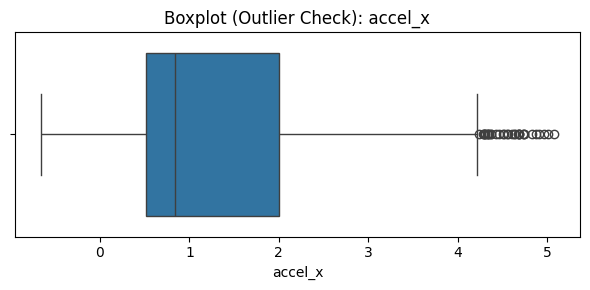

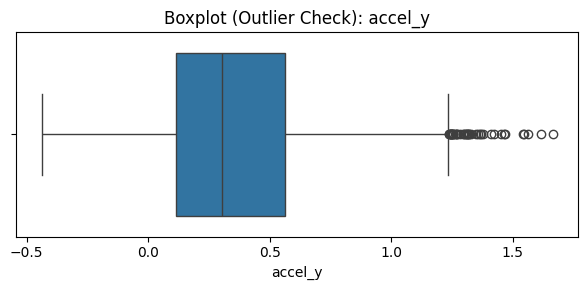

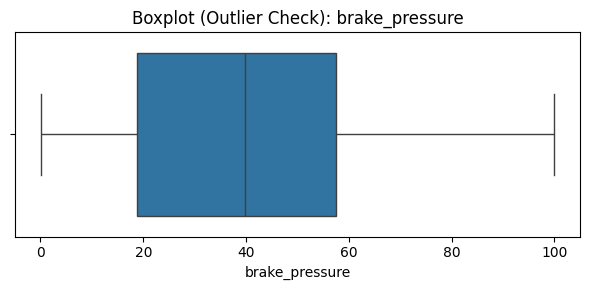

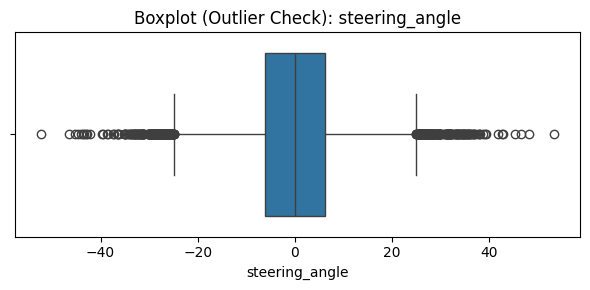

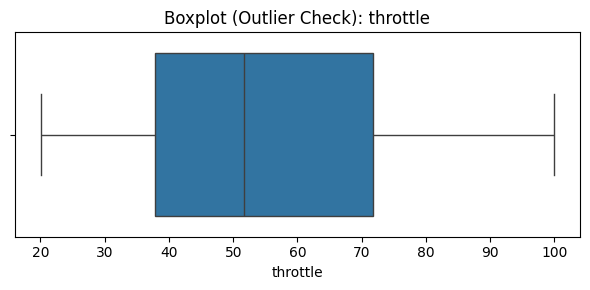

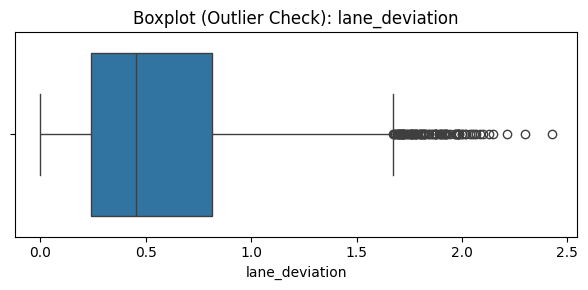

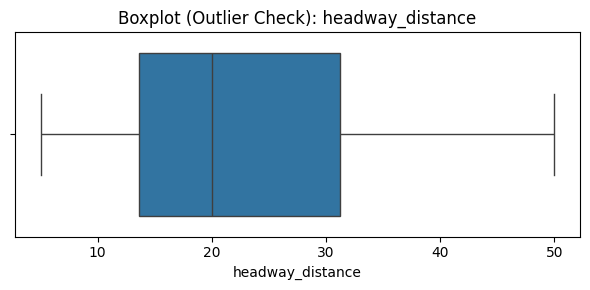

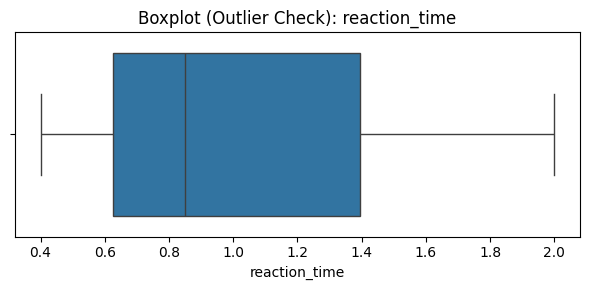

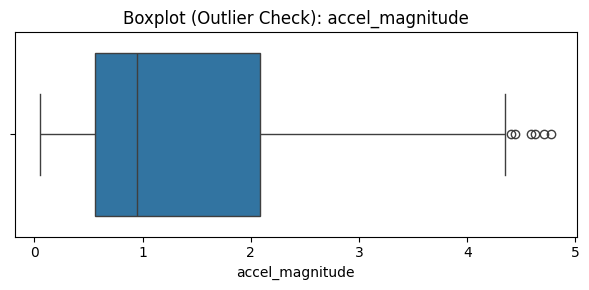

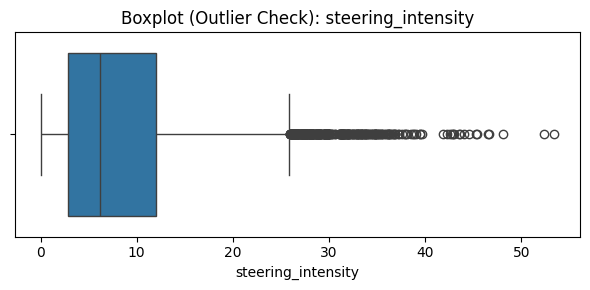

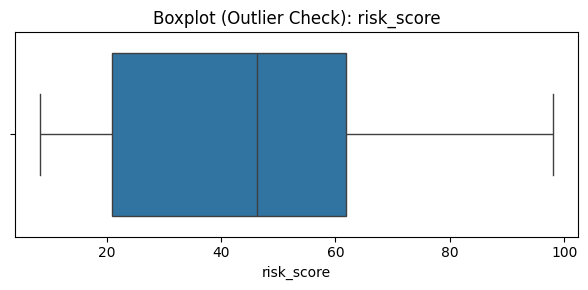

In [ ]:
num_cols_to_check = [
    "accel_x", "accel_y",
    "brake_pressure",
    "steering_angle",
    "throttle",
    "lane_deviation",
    "headway_distance",
    "reaction_time",
    "accel_magnitude",
    "steering_intensity",
    "risk_score"
]

for col in num_cols_to_check:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot (Outlier Check): {col}")
    plt.tight_layout()
    plt.show()


In [ ]:
def iqr_outlier_count(series):
    series = series.dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, lower, upper

outlier_rows = []
for col in num_cols_to_check:
    out_count, lower, upper = iqr_outlier_count(df_clean[col])
    outlier_rows.append({
        "Feature": col,
        "Outlier_Count": out_count,
        "Outlier_Percentage": round((out_count / df_clean[col].notna().sum()) * 100, 2),
        "Lower_Bound": round(lower, 4),
        "Upper_Bound": round(upper, 4)
    })

outlier_table = pd.DataFrame(outlier_rows).sort_values("Outlier_Count", ascending=False)
display(outlier_table)


,Feature,Outlier_Count,Outlier_Percentage,Lower_Bound,Upper_Bound
3,steering_angle,349,4.31,-24.8782,24.9061
9,steering_intensity,308,3.80,-11.0191,25.8983
5,lane_deviation,95,1.76,-0.6229,1.6735
1,accel_y,41,0.55,-0.5572,1.2374
0,accel_x,34,0.40,-1.7227,4.2299
8,accel_magnitude,6,0.28,-1.7119,4.3561
2,brake_pressure,0,0.00,-39.5322,115.7180
6,headway_distance,0,0.00,-12.7499,57.5638
4,throttle,0,0.00,-13.3342,122.9176
7,reaction_time,0,0.00,-0.5270,2.5481


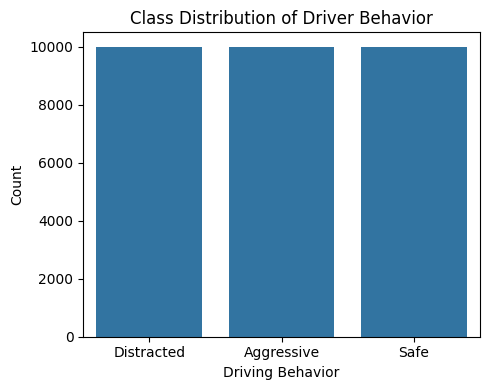

In [ ]:
plt.figure(figsize=(5, 4))
sns.countplot(x="behavior_label", data=df_clean)
plt.title("Class Distribution of Driver Behavior")
plt.xlabel("Driving Behavior")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


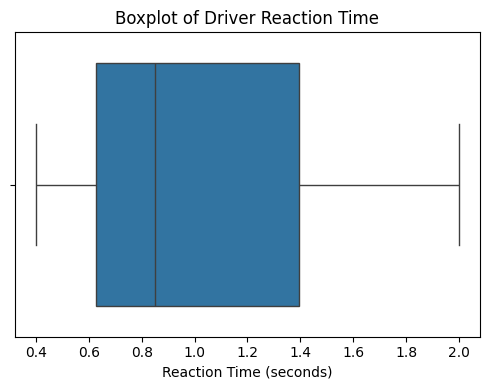

In [ ]:
plt.figure(figsize=(5, 4))
sns.boxplot(x=df_clean["reaction_time"])
plt.title("Boxplot of Driver Reaction Time")
plt.xlabel("Reaction Time (seconds)")
plt.tight_layout()
plt.show()


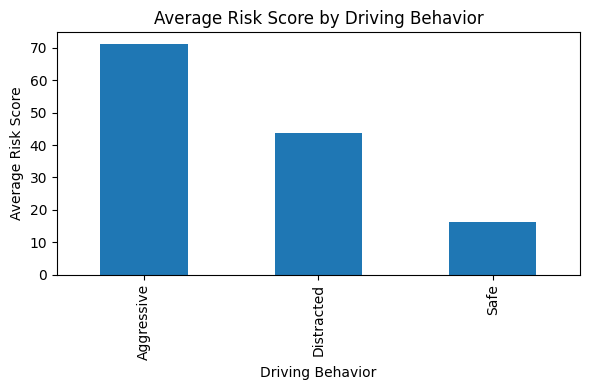

In [ ]:
plt.figure(figsize=(6, 4))
df_clean.groupby("behavior_label")["risk_score"].mean().plot(kind="bar")
plt.title("Average Risk Score by Driving Behavior")
plt.ylabel("Average Risk Score")
plt.xlabel("Driving Behavior")
plt.tight_layout()
plt.show()


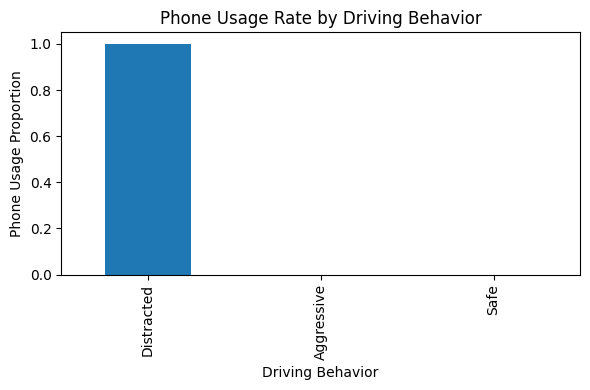

In [ ]:
plt.figure(figsize=(6, 4))
(df_clean.groupby("behavior_label")["phone_usage"].mean()
 .sort_values(ascending=False)
 .plot(kind="bar"))
plt.title("Phone Usage Rate by Driving Behavior")
plt.ylabel("Phone Usage Proportion")
plt.xlabel("Driving Behavior")
plt.tight_layout()
plt.show()


In [ ]:
# Separate features and target
X = df_clean.drop(columns=["behavior_label"])
y = df_clean["behavior_label"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (24000, 12)
Test size: (6000, 12)


In [ ]:
# Identify numerical features (all except target already removed)
numeric_features = X.columns.tolist()

# Standard scaling
scaler = StandardScaler()

# Fit on training data, transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Separate features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [ ]:
def evaluate_and_print(name, model, X_train, y_train, X_test, y_test):
    # Train model
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Metrics
    results = {
        "Model": name,
        "Train_Acc": accuracy_score(y_train, train_pred),
        "Test_Acc": accuracy_score(y_test, test_pred),
        "Precision": precision_score(y_test, test_pred, average="weighted"),
        "Recall": recall_score(y_test, test_pred, average="weighted"),
        "F1": f1_score(y_test, test_pred, average="weighted")
    }

    print("\n==============================")
    print("Model:", name)
    print("Train Accuracy:", round(results["Train_Acc"], 4))
    print("Test Accuracy:", round(results["Test_Acc"], 4))

    print("\nClassification Report (TEST):")
    print(classification_report(y_test, test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return results


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Model: Logistic Regression (Baseline)
Train Accuracy: 0.77
Test Accuracy: 0.7747

Classification Report (TEST):
              precision    recall  f1-score   support

  Aggressive       0.83      0.78      0.80      2000
  Distracted       0.67      0.73      0.70      2000
        Safe       0.84      0.82      0.83      2000

    accuracy                           0.77      6000
   macro avg       0.78      0.77      0.78      6000
weighted avg       0.78      0.77      0.78      6000



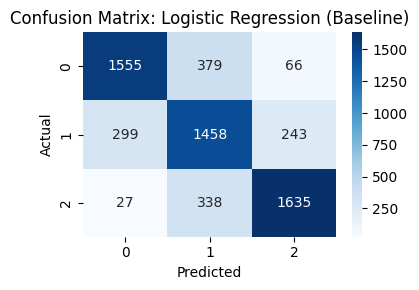


Model: Random Forest (Baseline)
Train Accuracy: 0.935
Test Accuracy: 0.8368

Classification Report (TEST):
              precision    recall  f1-score   support

  Aggressive       0.88      0.80      0.83      2000
  Distracted       0.87      0.78      0.82      2000
        Safe       0.78      0.93      0.85      2000

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



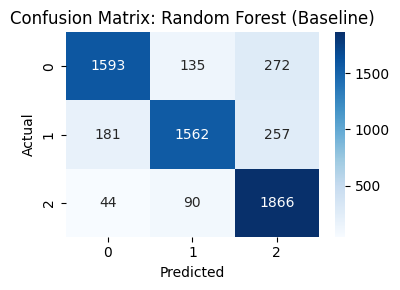

,Model,Train_Acc,Test_Acc,Precision,Recall,F1
0,Logistic Regression (Baseline),0.770042,0.774667,0.779361,0.774667,0.776297
1,Random Forest (Baseline),0.935000,0.836833,0.843150,0.836833,0.836181


In [ ]:
log_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        multi_class="auto",
        random_state=RANDOM_STATE
    ))
])

rf_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    ))
])

baseline_results = []

baseline_results.append(
    evaluate_and_print(
        "Logistic Regression (Baseline)",
        log_baseline,
        X_train, y_train,
        X_test, y_test
    )
)

baseline_results.append(
    evaluate_and_print(
        "Random Forest (Baseline)",
        rf_baseline,
        X_train, y_train,
        X_test, y_test
    )
)

baseline_df = pd.DataFrame(baseline_results)
baseline_df


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



Model: Neural Network (MLP)
Train Accuracy: 0.8407
Test Accuracy: 0.8453

Classification Report (TEST):
              precision    recall  f1-score   support

  Aggressive       0.77      0.89      0.83      2000
  Distracted       0.88      0.79      0.84      2000
        Safe       0.90      0.86      0.88      2000

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



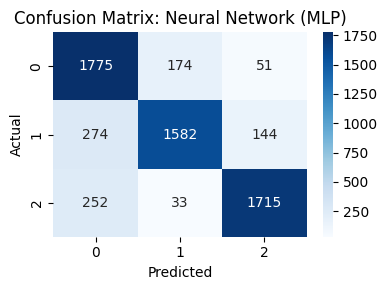

,Model,Train_Acc,Test_Acc,Precision,Recall,F1
0,Neural Network (MLP),0.840708,0.845333,0.851201,0.845333,0.845892


In [ ]:
mlp_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=0.0001,
        max_iter=50,
        random_state=RANDOM_STATE
    ))
])

mlp_results = evaluate_and_print("Neural Network (MLP)", mlp_model, X_train, y_train, X_test, y_test)
pd.DataFrame([mlp_results])


In [ ]:
# Safe sample size
sample_size = min(30000, X_train.shape[0])

# Sample from ORIGINAL X_train
X_train_tune = X_train.sample(
    n=sample_size,
    random_state=RANDOM_STATE
)

# Matching y values (same index)
y_train_tune = y_train.loc[X_train_tune.index]

print("Tuning subset shape:", X_train_tune.shape)
print("\nTuning class distribution:")
print(y_train_tune.value_counts(normalize=True))


Tuning subset shape: (24000, 12)

Tuning class distribution:
behavior_label
Safe          0.333333
Aggressive    0.333333
Distracted    0.333333
Name: proportion, dtype: float64


In [ ]:


cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

log_tune = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=3000,
        solver="lbfgs",
        multi_class="auto",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

log_param_dist = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

log_search = RandomizedSearchCV(
    estimator=log_tune,
    param_distributions=log_param_dist,
    n_iter=6,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=1,
    random_state=RANDOM_STATE,
    verbose=1
)


log_search.fit(X_train, y_train)

print("Best Logistic Params:", log_search.best_params_)
print("Best Logistic CV F1:", round(log_search.best_score_, 4))


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best Logistic Params: {'model__C': 100}
Best Logistic CV F1: 0.7711


In [ ]:


# Random Forest model
rf = RandomForestClassifier(
    random_state=RANDOM_STATE
)

# Hyperparameter search space
rf_param_dist = {
    "n_estimators": [120, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Randomized Search with Cross-Validation
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=8,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit on unscaled training data
rf_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_search.best_params_)
print("Best Random Forest CV F1-score:", round(rf_search.best_score_, 4))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Random Forest CV F1-score: 0.8511


In [ ]:
# Baseline Logistic Regression sanity check (PIPELINE VERSION)

log_sanity = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        multi_class="auto",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# Train
log_sanity.fit(X_train, y_train)

# Predict
pred = log_sanity.predict(X_test)

print("Predicted class counts:")
print(pd.Series(pred).value_counts())

print("\nClassification Report (Baseline Logistic Regression):")
print(classification_report(y_test, pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Predicted class counts:
Distracted    2175
Safe          1944
Aggressive    1881
Name: count, dtype: int64

Classification Report (Baseline Logistic Regression):
              precision    recall  f1-score   support

  Aggressive       0.83      0.78      0.80      2000
  Distracted       0.67      0.73      0.70      2000
        Safe       0.84      0.82      0.83      2000

    accuracy                           0.77      6000
   macro avg       0.78      0.77      0.78      6000
weighted avg       0.78      0.77      0.78      6000



In [ ]:



all_feature_names = X_train.columns.tolist()


imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# 3. Feature Selection
k_features = 10  # Selecting top 10 features
selector = SelectKBest(score_func=mutual_info_classif, k=k_features)

# Fit on the IMPUTED data
selector.fit(X_train_imputed, y_train)

# 4. Extract Results
selected_mask = selector.get_support()
selected_features = np.array(all_feature_names)[selected_mask]
selected_scores = selector.scores_[selected_mask]

# Create results table
selected_df = pd.DataFrame({
    "Selected_Feature": selected_features,
    "Mutual_Info_Score": selected_scores
}).sort_values("Mutual_Info_Score", ascending=False)

print("Features selected based on Mutual Information:")
display(selected_df)
print(f"Features before selection: {X_train.shape[1]}")
print(f"Features after selection: {k_features}")

Features selected based on Mutual Information:


,Selected_Feature,Mutual_Info_Score
7,reaction_time,0.220777
6,headway_distance,0.196219
2,brake_pressure,0.180786
3,throttle,0.178128
0,accel_x,0.166625
5,phone_usage,0.129403
1,accel_y,0.127364
4,lane_deviation,0.103736
8,accel_magnitude,0.050961
9,steering_intensity,0.043064


Features before selection: 12
Features after selection: 10



Model: Logistic Regression (Final: Tuned + Selected)
Train Accuracy: 0.7572
Test Accuracy: 0.7605

Classification Report (TEST):
              precision    recall  f1-score   support

  Aggressive       0.82      0.77      0.79      2000
  Distracted       0.65      0.73      0.68      2000
        Safe       0.83      0.79      0.81      2000

    accuracy                           0.76      6000
   macro avg       0.77      0.76      0.76      6000
weighted avg       0.77      0.76      0.76      6000



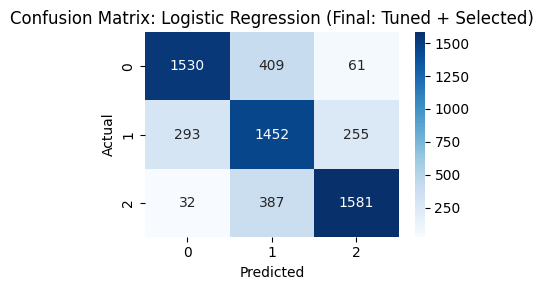


Model: Random Forest (Final: Tuned + Selected)
Train Accuracy: 0.8572
Test Accuracy: 0.8502

Classification Report (TEST):
              precision    recall  f1-score   support

  Aggressive       0.75      0.94      0.84      2000
  Distracted       0.94      0.75      0.84      2000
        Safe       0.91      0.85      0.88      2000

    accuracy                           0.85      6000
   macro avg       0.87      0.85      0.85      6000
weighted avg       0.87      0.85      0.85      6000



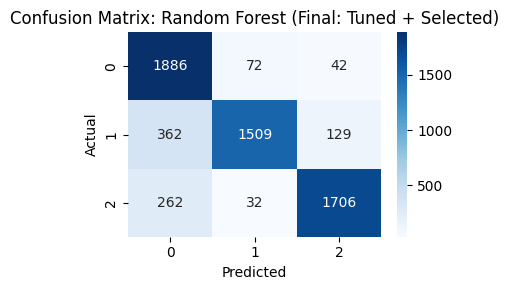

,Model,Train_Acc,Test_Acc,Precision,Recall,F1
0,Logistic Regression (Final: Tuned + Selected),0.757167,0.760500,0.768042,0.760500,0.762928
1,Random Forest (Final: Tuned + Selected),0.857167,0.850167,0.865272,0.850167,0.850581


In [ ]:
final_log = Pipeline(steps=[
    ("preprocess", preprocessor),

    ("select", SelectKBest(mutual_info_classif, k=k_features)),
    ("model", LogisticRegression(
        max_iter=3000,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        # Using the best C=100 found during tuning
        C=log_search.best_params_["model__C"],
        penalty="l2",
        solver="lbfgs"
    ))
])


final_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(mutual_info_classif, k=k_features)),
    ("model", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        # Updated keys based on your tuning output
        n_estimators=rf_search.best_params_["n_estimators"],
        max_depth=rf_search.best_params_["max_depth"],
        min_samples_split=rf_search.best_params_["min_samples_split"],
        min_samples_leaf=rf_search.best_params_["min_samples_leaf"],
        max_features=rf_search.best_params_["max_features"]
    ))
])

# Evaluate the models
final_results = []

final_results.append(
    evaluate_and_print(
        "Logistic Regression (Final: Tuned + Selected)",
        final_log,
        X_train, y_train, X_test, y_test
    )
)

final_results.append(
    evaluate_and_print(
        "Random Forest (Final: Tuned + Selected)",
        final_rf,
        X_train, y_train, X_test, y_test
    )
)

# Combine and show results
final_df = pd.DataFrame(final_results)
display(final_df)

In [ ]:
comparison_table = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Features": f"Selected (k={k_features})",
        "CV Score": log_search.best_score_,
        "Accuracy": final_results[0]["Test_Acc"],
        "Precision": final_results[0]["Precision"],
        "Recall": final_results[0]["Recall"],
        "F1-Score": final_results[0]["F1"]
    },
    {
        "Model": "Random Forest",
        "Features": f"Selected (k={k_features})",
        "CV Score": rf_search.best_score_,
        "Accuracy": final_results[1]["Test_Acc"],
        "Precision": final_results[1]["Precision"],
        "Recall": final_results[1]["Recall"],
        "F1-Score": final_results[1]["F1"]
    }
])

comparison_table

,Model,Features,CV Score,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Selected (k=10),0.771052,0.760500,0.768042,0.760500,0.762928
1,Random Forest,Selected (k=10),0.851131,0.850167,0.865272,0.850167,0.850581
